In [125]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import logging
from collections import Counter
from collections import defaultdict

import gensim
from gensim.parsing.preprocessing import STOPWORDS

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

import torch
from torchtext import data, datasets

import re
import html
re1 = re.compile(r'  +')

In [2]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [3]:
data_path = Path("../data/processed/") / "aclImdb"

In [4]:
spacy_en = spacy.load('en')
def tokenizer(text): # create a tokenizer function
    return [tok.lemma_ for tok in spacy_en.tokenizer(fixup(text)) if tok.text not in STOPWORDS]

In [5]:
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True, tokenize=tokenizer)
LABEL = data.Field(sequential=False)

# train_ds = datasets.IMDB(str(data_path / "train"), TEXT, LABEL)
test_ds = datasets.IMDB(str(data_path / "test"), TEXT, LABEL)

In [ ]:
0.2

In [71]:
dictionary = gensim.corpora.Dictionary([ex.text for ex in test_ds.examples])
# dictionary.filter_extremes(no_below=500, no_above=0.2)
corpus = [dictionary.doc2bow(ex.text) for ex in test_ds.examples]
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
print(len(dictionary))

72044


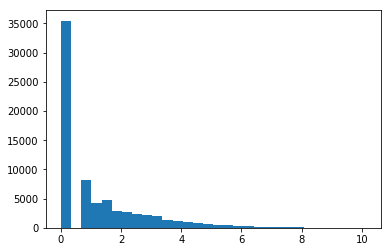

In [72]:
plt.hist(np.log([v for k, v in tfidf_model.dfs.items()]), bins=30);

In [81]:
dictionary = gensim.corpora.Dictionary([ex.text for ex in test_ds.examples])
dictionary.filter_extremes(no_below=100, no_above=0.05)
corpus = [dictionary.doc2bow(ex.text) for ex in test_ds.examples]
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
print(len(dictionary))

2875


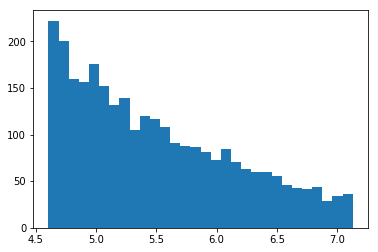

In [82]:
plt.hist(np.log([v for k, v in tfidf_model.dfs.items()]), bins=30);

In [83]:
idx = 701
sorted([(dictionary[k], v) for k, v in tfidf_model[corpus[idx]]], key=lambda k: -k[1])[:10]

[('anti', 0.318891792937833),
 ('emotional', 0.2976598209655677),
 ('metaphor', 0.21835526371846756),
 ('divide', 0.21608670397364427),
 ('reel', 0.21290988970788643),
 ('happiness', 0.21092502659998008),
 ("don't", 0.20635804106142905),
 ('mirror', 0.19855080805862926),
 ('nose', 0.1962560076579633),
 ('largely', 0.1932510818831198)]

In [60]:
" ".join(test_ds.examples[idx].text)

"as haneke film , decision -- don't sway read interest medium film unique end , . isabelle huppert stun film -- combine haneke , pull punch . haneke reel lure golden boy , benoit magimel , anti - romance funny games anti - thriller . -pron- will force watch catharsis range sustain anxiety kind emotional release have incredibly nervy think provoke ; haneke continue hold mirror desensitise western civilization . people turn nose have take solondz happiness step . while ground reality , erika ( huppert ) view emotional metaphor . -pron- be recommend i not dissuade ... definitely divide people give have largely repression -- have surprise ."

In [84]:
clipped_corpus = gensim.utils.ClippedCorpus(corpus, 25000)
lda_model = gensim.models.ldamulticore.LdaMulticore(clipped_corpus, num_topics=20, id2word=dictionary, passes=10, workers=6)

In [86]:
# lda_model.print_topics()

In [93]:
bow_vector = dictionary.doc2bow(tokenizer("hi there movie nice horror film hitchcock"))

In [147]:
idx = 500
" ".join(test_ds.examples[idx].text)

'i like film -pron- be glad have available finally dvd viewer i tell year . story high school virgin name gary ( lawrence monoson ) work pizza place delivery boy hang friend david ( joe rubbo ) rick ( steve antin ) . gary notice karen ( diane franklin ) new girl school morning give ride time totally love . that night party have rick karen jealous well friend not tell true feeling . \n\n * * * * * spoiler alert * * * * * \n\n rick ask gary borrow grandmothers vacant home gary make excuse rick can not karen . but night rick brag gary nail football field gary enrage . a day late school library gary have rick karen argue ask karen wrong . she tell have pregnant rick dump . gary help take grandmothers home pay abortion . finally , gary tell karen feel receptive feeling late birthday party walk karen rick . gary drive girl ! this film end realistic version life . no matt nice not necessarily girl . \n\n this film direct boaz davidson pretty competent action film director thing right movie . 

In [148]:
lda_vector = lda_model[corpus[idx]]
lda_vector

[(3, 0.23084733),
 (4, 0.22997618),
 (8, 0.11202479),
 (11, 0.16568269),
 (14, 0.013028879),
 (16, 0.24177344)]

In [149]:
topic_words = defaultdict(list)
for tok in set(test_ds.examples[idx].text):
    if tok in dictionary.token2id:
        tok_topics = sorted(lda_model.get_term_topics(dictionary.token2id[tok], 0.000001), key=lambda x: -x[1])
        max_topics = tok_topics[:3]
        for topic, pct in max_topics:
            topic_words[topic].append((tok, pct))

In [150]:
for topic, pct in lda_vector:
    wrds = sorted(topic_words[topic], key=lambda x: -x[1])
    print(topic, sorted(wrds, key=lambda k: -k[1])[:3])

3 [('*', 0.21744148), ('spoiler', 0.0046000457), ('steve', 0.0032371876)]
4 [('win', 0.009159933), ('pay', 0.0047139246), ('level', 0.0038643857)]
8 [('sex', 0.0064130006), ('drive', 0.0047701164), ('nudity', 0.0034307502)]
11 [('song', 0.015052232), ('actress', 0.0032898912), ('lawrence', 0.0013627892)]
14 [('david', 0.003968701), ('sex', 0.003444649), ('name', 0.0033565562)]
16 [('sex', 0.016707534), ('actress', 0.0044651655), ('teen', 0.0034611037)]
